In [58]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [59]:
from keras import backend as K
from keras.applications.vgg16 import VGG16
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [60]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Keras modules

In [62]:
import keras
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model,Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input,Add

## Cargo datos

In [63]:
from keras.datasets import cifar10
((x, y), (x_test,y_test)) = cifar10.load_data()

In [64]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [65]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [66]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

## Red neuronal: Transfer learning con VGG16

In [67]:
preproc=VGG16(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))

In [68]:
preproc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [69]:
for layer in preproc.layers:
    layer.trainable=False

In [70]:
x_pre_train=preproc.predict(x_train)
x_pre_valid=preproc.predict(x_valid)

In [71]:
x_pre_train[0].shape

(1, 1, 512)

In [72]:
input_preproc=Input(shape=(1,1,512))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=10, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total para

In [73]:
# Callbacks
checkpoint_file='checkpoint.cifar10-cnn-TL-VGG16.hdf5'
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_acc",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [74]:
x_train.shape

(45000, 32, 32, 3)

In [75]:
y_train_categorical.shape

(45000, 10)

In [76]:
batch_size = 64
epocs = 100

history = model.fit(x_pre_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_pre_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 1s 32us/step - loss: 1.9860 - acc: 0.2889 - val_loss: 1.6808 - val_acc: 0.4142

Epoch 00001: val_acc improved from -inf to 0.41420, saving model to checkpoint.cifar10-cnn-TL-VGG16.hdf5
Epoch 2/100
45000/45000 [==============================] - 1s 24us/step - loss: 1.6559 - acc: 0.4131 - val_loss: 1.5276 - val_acc: 0.4538

Epoch 00002: val_acc improved from 0.41420 to 0.45380, saving model to checkpoint.cifar10-cnn-TL-VGG16.hdf5
Epoch 3/100
45000/45000 [==============================] - 1s 25us/step - loss: 1.5352 - acc: 0.4594 - val_loss: 1.4274 - val_acc: 0.4958

Epoch 00003: val_acc improved from 0.45380 to 0.49580, saving model to checkpoint.cifar10-cnn-TL-VGG16.hdf5
Epoch 4/100
45000/45000 [==============================] - 1s 25us/step - loss: 1.4713 - acc: 0.4826 - val_loss: 1.3792 - val_acc: 0.5138

Epoch 00004: val_acc improved from 0.49580 to 0.51380, saving model to che

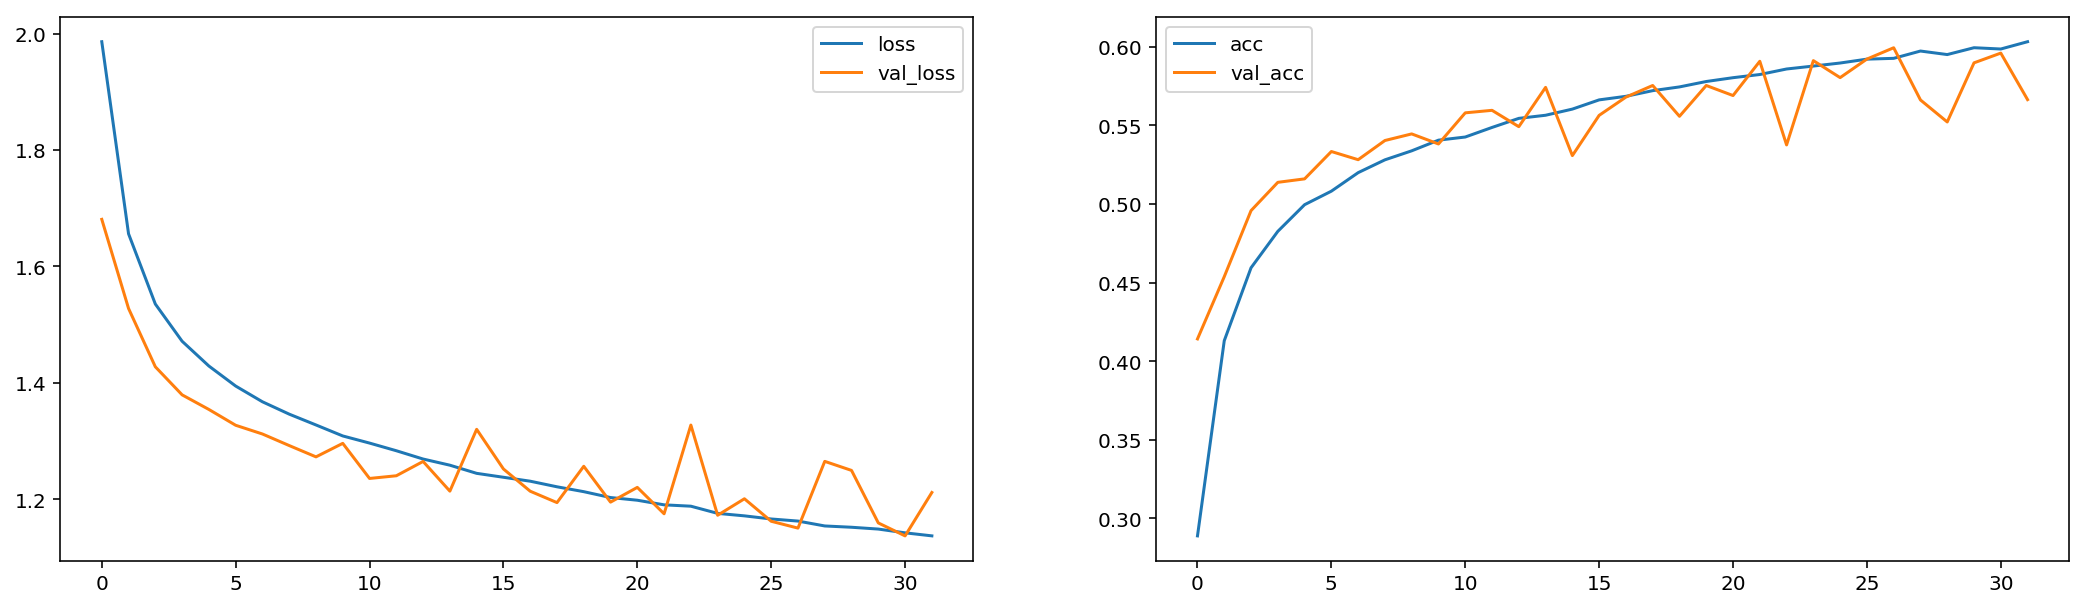

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['acc'], label="acc")
ax2.plot(history.history['val_acc'], label="val_acc")
ax2.legend()
plt.show();

In [78]:
model.load_weights('checkpoint.cifar10-cnn-TL-VGG16.hdf5')

In [79]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [80]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [81]:
total_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Callbacks
checkpoint_file='checkpoint.cifar10-cnn-TL-VGG16_fine_tunning.hdf5'
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_acc",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [82]:
batch_size = 64
epocs = 100

history = total_model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 18s 398us/step - loss: 1.2997 - acc: 0.5509 - val_loss: 1.1618 - val_acc: 0.5988

Epoch 00001: val_acc improved from -inf to 0.59880, saving model to checkpoint.cifar10-cnn-TL-VGG16_fine_tunning.hdf5
Epoch 2/100
45000/45000 [==============================] - 17s 382us/step - loss: 0.6904 - acc: 0.7665 - val_loss: 2.4028 - val_acc: 0.4134

Epoch 00002: val_acc did not improve from 0.59880
Epoch 3/100
45000/45000 [==============================] - 17s 387us/step - loss: 0.5357 - acc: 0.8188 - val_loss: 0.7492 - val_acc: 0.7570

Epoch 00003: val_acc improved from 0.59880 to 0.75700, saving model to checkpoint.cifar10-cnn-TL-VGG16_fine_tunning.hdf5
Epoch 4/100
45000/45000 [==============================] - 17s 385us/step - loss: 0.4323 - acc: 0.8538 - val_loss: 0.4778 - val_acc: 0.8402

Epoch 00004: val_acc improved from 0.75700 to 0.84020, saving model to checkpoint.cifar10-cnn-TL-V